In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# 1. Configuración inicial
LOCAL_IMAGE_PATH = './repo_dataset'
TARGET_SIZE = (224, 224)
TARGET_SIZE_CHANNEL = (224, 224, 3)
BATCH_SIZE = 32

#cargar csv y dividir en dev set y test set
# Load the dataset into a DataFrame
CSV_PATH = '.\mobilnet-multi-label-solo-local.csv'
df = pd.read_csv(CSV_PATH)

# Columnas de clases
LABEL_COLUMNS = ['direccion', 'fachada', 'envio', 'etiqueta']

# Shuffle the dataset
# 20% dev set 
#20% test set
sample_df = df.sample(n=int(len(df)*0.1))
print(f'Length dataset {len(df)}, length saamples {len(sample_df)}')

Length dataset 16219, length saamples 1621


In [3]:
# cargar las imagenes
def prepare_image(row, local_image_path, label_columns, target_size):
    # Preparar las etiquetas
    labels = row[label_columns].values.astype(int)
    
    # Cargar desde archivo local
    img_path = os.path.join(local_image_path, row['filename'])
    if os.path.exists(img_path):
        image = Image.open(img_path)
        
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar
    
    return image, np.array(labels)

In [4]:
def print_class_distribution(X, y, label_columns):
    print(f"Dataset preparado con {len(X)} imágenes")
    print(f"Distribución de clases:")
    for i, col in enumerate(label_columns):
        positive_samples = np.sum(y[:, i])
        percentage = (positive_samples / len(y)) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{len(y)})")

In [5]:
def prepare_dataset(df, local_image_path, label_columns, target_size, max_workers=4):
    labels = []
    images = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Procesar cada fila del DataFrame
        futures = [executor.submit(prepare_image, row, local_image_path, label_columns, target_size) 
                   for _, row in df.iterrows()]
          
        # Recolectar resultados con barra de progreso
        for future in tqdm(futures, total=len(df)):
            result = future.result()
            if result is not None:
                img_array, img_labels = result
                images.append(img_array)
                labels.append(img_labels)

    # Convertir a arrays numpy
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [6]:
print('prepare_dataset...')

X,y = prepare_dataset(sample_df, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)        

print('prepare_dataset OK')

print_class_distribution(X, y, LABEL_COLUMNS)

prepare_dataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1621/1621 [00:08<00:00, 196.94it/s]


prepare_dataset OK
Dataset preparado con 1621 imágenes
Distribución de clases:
direccion: 13.20% (214/1621)
fachada: 13.08% (212/1621)
envio: 75.20% (1219/1621)
etiqueta: 57.13% (926/1621)


In [7]:
# Dividir el dataset en dev=50% y test=50%
def split_dataset(X, y, test_size=0.2, random_state=42):
    return train_test_split(
            X, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y.sum(axis=1)  # Estratificar por número total de etiquetas
        )


print('split_dataset...')
# Dividir en train y test
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.5)

print(f'X_train: {len(X_train)}, y_train: {len(y_train)}, X_test: {len(X_test)}, y_test {len(y_test)}')

print('split_dataset. OK')

print_class_distribution(X_train, y_train, LABEL_COLUMNS)

print('liberarndo X y y')
del X
del y

split_dataset...
X_train: 810, y_train: 810, X_test: 811, y_test 811
split_dataset. OK
Dataset preparado con 810 imágenes
Distribución de clases:
direccion: 13.95% (113/810)
fachada: 12.84% (104/810)
envio: 75.19% (609/810)
etiqueta: 56.67% (459/810)
liberarndo X y y


In [8]:
class MultiLabelSMOTE:
    def __init__(self, k_neighbors=5, target_samples=500, random_state=None):
        self.k_neighbors = k_neighbors
        self.target_samples = target_samples  # Número objetivo de muestras por clase
        self.random_state = random_state
    
    def _reshape_for_knn(self, X):
        """Reshape the input data for KNN if necessary."""
        original_shape = X.shape
        if len(original_shape) > 2:
            # Aplanar todas las dimensiones excepto la primera (muestras)
            n_samples = original_shape[0]
            X_reshaped = X.reshape(n_samples, -1)
            return X_reshaped, original_shape
        return X, original_shape

    def _restore_shape(self, X, original_shape):
        """Restaura la forma original de los datos."""
        if len(original_shape) > 2:
            return X.reshape((-1,) + original_shape[1:])
        return X

    def _balance_label(self, X, y, label_idx):
        # Indices de instancias con la etiqueta activa
        idx = np.where(y[:, label_idx] == 1)[0]
        X_label = X[idx]
        y_label = y[idx]
        
        # Si ya hay suficientes muestras, no hacer nada
        if len(X_label) >= self.target_samples:
            return X_label, y_label

         # Reshape data for KNN
        X_reshaped, original_shape = self._reshape_for_knn(X_label)
        
        # Calcular cuántas muestras sintéticas se necesitan
        n_needed = self.target_samples - len(X_label)
        
        # Encontrar vecinos más cercanos
        knn = NearestNeighbors(n_neighbors=self.k_neighbors)
        knn.fit(X_reshaped)
        distances, indices = knn.kneighbors(X_reshaped)
        
        # Generar muestras sintéticas
        synthetic_X = []
        synthetic_y = []
        
        for _ in range(n_needed):
            i = np.random.randint(0, len(X_label))
            neighbor_idx = np.random.choice(indices[i])
            gap = np.random.uniform(0, 1)

            # Generar muestra sintética en el espacio aplanado
            synthetic = X_reshaped[i] + gap * (X_reshaped[neighbor_idx] - X_reshaped[i])
            synthetic_X.append(synthetic)
            synthetic_y.append(y_label[i])

         # Convertir a arrays y restaurar la forma original
        synthetic_X = np.array(synthetic_X)
        synthetic_X = self._restore_shape(synthetic_X, original_shape)
            
        return np.vstack([X_label, synthetic_X]), np.vstack([y_label, synthetic_y])
    
    def fit_resample(self, X, y):
        np.random.seed(self.random_state)
        X_balanced, y_balanced = X.copy(), y.copy()
        
        for label_idx in range(y.shape[1]):
            # Balancear cada etiqueta individualmente
            X_bal, y_bal = self._balance_label(X_balanced, y_balanced, label_idx)

            # Combinar con los datos existentes
            X_balanced = np.vstack([X_balanced, X_bal])
            y_balanced = np.vstack([y_balanced, y_bal])

        # Eliminar duplicados
        unique_indices = np.unique(X_balanced.reshape(X_balanced.shape[0], -1), axis=0, return_index=True)[1]
        X_balanced = X_balanced[unique_indices]
        y_balanced = y_balanced[unique_indices]
        return X_balanced, y_balanced


In [9]:
# 2. Cargar modelo base (MobileNetV3 Large)
# Aplicar SMOTE adaptado
print('MultiLabelSMOTE...')
mlsmote = MultiLabelSMOTE(target_samples=1000, k_neighbors=3, random_state=42)
X_bal, y_bal = mlsmote.fit_resample(X_train, y_train)

print(f'X_bal: {len(X_bal)}, y_bal: {len(y_bal)}')

# Verificar balanceo
print("Conteo original por clase:", y_train.sum(axis=0))
print("Conteo balanceado por clase:", y_bal.sum(axis=0))

print_class_distribution(X_bal, y_bal, LABEL_COLUMNS)
print('MultiLabelSMOTE OK')

MultiLabelSMOTE...
X_bal: 1738, y_bal: 1738
Conteo original por clase: [113 104 609 459]
Conteo balanceado por clase: [793 557 859 621]
Dataset preparado con 1738 imágenes
Distribución de clases:
direccion: 45.63% (793/1738)
fachada: 32.05% (557/1738)
envio: 49.42% (859/1738)
etiqueta: 35.73% (621/1738)
MultiLabelSMOTE OK


In [10]:
'''
# 1. Calcular pesos de clases adaptativos
def calculate_class_weights(labels, alpha=0.5, smooth=1e-6):
    """
    alpha: Factor de balanceo (0.5 para énfasis moderado en clases raras)
    smooth: Suavizado para evitar divisiones por cero
    """
    class_counts = np.sum(labels, axis=0) + smooth
    weights = (1 / class_counts)**alpha  # Función no-lineal para mayor énfasis en clases minoritarias
    return weights / np.max(weights)  # Normalizar a [0, 1]

# 2. Función de aumento de datos adaptativo

class AdaptiveAugmenter(layers.Layer):
    def __init__(self, class_weights, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        
        # Configurar transformaciones con parámetros conservadores
        self.rotation = layers.RandomRotation(
            factor=0.15,  # ±15% de rotación máxima
            fill_mode='reflect',  # Evitar bordes negros
            interpolation='bilinear'
        )
        self.zoom = layers.RandomZoom(
            height_factor=0.1,  # ±10% de zoom máximo
            width_factor=0.1,
            fill_mode='reflect'
        )
        
        #self.brightness = layers.RandomBrightness(0.5)  # ±8% brillo
        self.brightness = self.adaptive_brightness
        self.contrast = layers.RandomContrast(0.08)      # ±8% contraste
        self.clip = layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))

    def get_sample_weight(self, label):
        # Estrategia mejorada: considerar el peso máximo y promedio
        active_weights = tf.boolean_mask(self.class_weights, tf.cast(label, tf.bool))
        max_weight = tf.reduce_max(active_weights) if tf.size(active_weights) > 0 else 0.0
        mean_weight = tf.reduce_mean(active_weights) if tf.size(active_weights) > 0 else 0.0
        return tf.sqrt(max_weight * mean_weight)  # Combinación no-lineal de métricas

    def adaptive_augment(self, image, weight):
       # Intensidad adaptativa no-lineal
        intensity = tf.minimum(1.0, weight**2)  # Función cuadrática para mayor sensibilidad
        
        # Aplicar transformaciones con probabilidad proporcional al peso
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.rotation(image)
            image = self.clip(image)
        
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.zoom(image)
            image = self.clip(image)
        
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.adaptive_brightness(image, weight)
            image = self.clip(image)
        
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.contrast(image)
            image = self.clip(image)
            
        return image
        
    def adaptive_brightness(self, image, weight):
        # Calcular delta basado en la intensidad y brillo actual
        current_brightness = tf.reduce_mean(image)
        # Calcular límites con conversión explícita
        max_delta = tf.cast(
            tf.minimum(0.1 * weight, 1.0 - current_brightness),
            tf.float32
        )
        min_delta = tf.cast(
            tf.maximum(-0.1 * weight, -current_brightness),
            tf.float32
        )
        
        # Generar delta con tipos consistentes
        delta = tf.random.uniform(
            shape=[],
            minval=min_delta,
            maxval=max_delta,
            dtype=tf.float32
        )
        
        return self.clip(image + delta)
         
    def call(self, image, label):
        #image, label = inputs
        if tf.reduce_max(image) > 1.0:
            image = tf.cast(image, tf.float32) / 255.0
        weight = self.get_sample_weight(label)

        # Probabilidad de aumentación dependiente del peso de forma no-lineal
        prob_aug = 0.9 * (1 - tf.exp(-3 * weight))  # Función exponencial
        
        augmented_image = tf.cond(
            tf.random.uniform([]) < prob_aug,
            lambda: self.adaptive_augment(image, weight),
            lambda: image
        )
        
        return augmented_image, label

def create_dataset(images, labels, class_weights, batch_size=32):  
    dataset = tf.data.Dataset.from_tensor_slices((tf.cast(images, tf.float32), labels))
    augmenter = AdaptiveAugmenter(class_weights)
        
    # Estrategia de muestreo combinada
    dataset = dataset.repeat()  # Muestreo infinito para balancear
    dataset = dataset.map(
        lambda x, y: augmenter(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(10*batch_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def visualize_augmented_images(dataset, class_names, num_samples=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            
            # Convertir tensor a numpy y asegurar rango
            img = images[i].numpy()
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            title = ', '.join([class_names[j] for j in np.where(labels[i])[0]])
            plt.title(title, fontsize=8)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Uso ejemplo:
# Asumiendo X_bal en rango 0-255 y y_bal one-hot encoded
print('Augmentation...')


# Calcular pesos de clases
class_weights = calculate_class_weights(y_bal, alpha=0.7)
train_dataset = create_dataset(X_bal, y_bal, class_weights, batch_size=BATCH_SIZE)
visualize_augmented_images(train_dataset, class_names=LABEL_COLUMNS)

# 3. Verificación de rango
print("Rango original - Min:", np.min(X_bal), "Max:", np.max(X_bal), "Len:", len(X_bal))
sample_images, _ = next(iter(train_dataset.take(1)))
print("Rango después de aumentación:", 
      np.min(sample_images.numpy()), 
      np.max(sample_images.numpy()))

print('Augmentation OK')
'''
a = None

Augmentation...


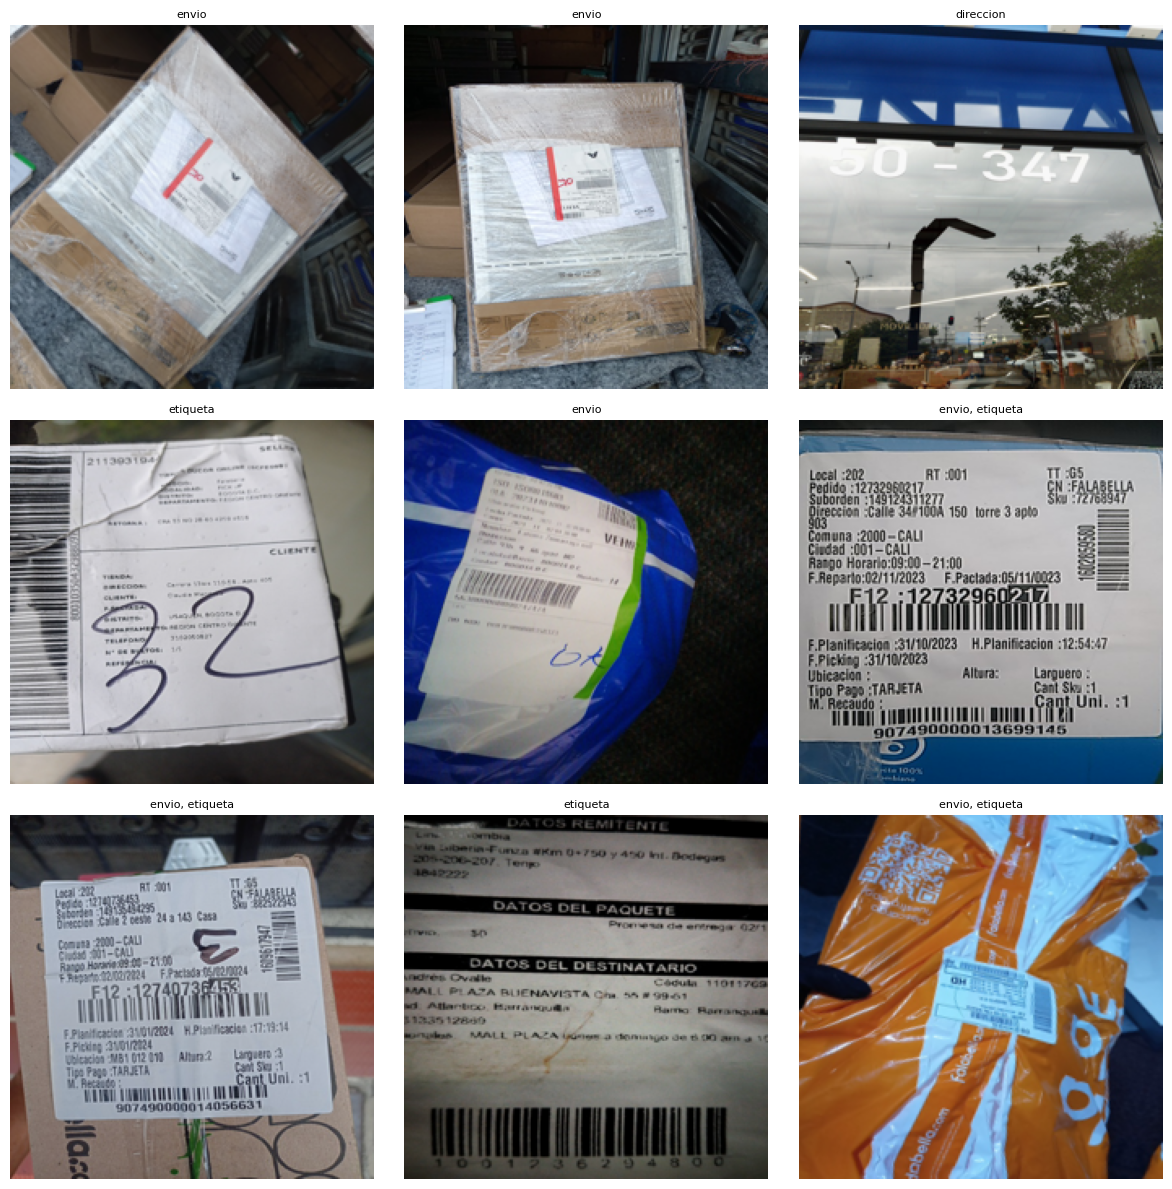

Augmentation OK


In [11]:
# 1. Calcular pesos de clases adaptativos
def calculate_class_weights(labels, alpha=0.7, smooth=1e-6):
    class_counts = np.sum(labels, axis=0) + smooth
    weights = (1 / class_counts) ** alpha  # Mayor énfasis en clases minoritarias
    return weights / np.max(weights)  # Normalización a [0, 1]

# 2. Data Augmentation Adaptativa
class AdaptiveAugmenter(layers.Layer):
    def __init__(self, class_weights, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        self.rotation = layers.RandomRotation(factor=0.15, fill_mode='reflect')
        self.zoom = layers.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode='reflect')
        self.contrast = layers.RandomContrast(0.08)
        self.clip = layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))

    def get_sample_weight(self, label):
        active_weights = tf.boolean_mask(self.class_weights, tf.cast(label, tf.bool))
        max_weight = tf.reduce_max(active_weights) if tf.size(active_weights) > 0 else 0.0
        mean_weight = tf.reduce_mean(active_weights) if tf.size(active_weights) > 0 else 0.0
        return tf.sqrt(max_weight * mean_weight)

    def adaptive_brightness(self, image, weight):
        # Calcular delta basado en la intensidad y brillo actual
        current_brightness = tf.reduce_mean(image)
        # Calcular límites con conversión explícita
        max_delta = tf.cast(
            tf.minimum(0.1 * weight, 1.0 - current_brightness),
            tf.float32
        )
        min_delta = tf.cast(
            tf.maximum(-0.1 * weight, -current_brightness),
            tf.float32
        )
        
        # Generar delta con tipos consistentes
        delta = tf.random.uniform(
            shape=[],
            minval=min_delta,
            maxval=max_delta,
            dtype=tf.float32
        )
        
        return self.clip(image + delta)

    def adaptive_augment(self, image, weight):
        intensity = tf.minimum(1.0, weight ** 2)
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.rotation(image)
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.zoom(image)
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.adaptive_brightness(image, weight)
        if tf.random.uniform([]) < 0.3 * intensity:
            image = self.contrast(image)
        return tf.clip_by_value(image, 0.0, 1.0)

    def call(self, image, label):
        weight = self.get_sample_weight(label)
        prob_aug = 0.9 * (1 - tf.exp(-3 * weight))
        return tf.cond(tf.random.uniform([]) < prob_aug, lambda: self.adaptive_augment(image, weight), lambda: image), label

# 3. Generación del dataset balanceado
def create_balanced_dataset(images, labels, class_weights, batch_size=32):
    sample_weights = np.max(labels * class_weights, axis=1)  # Ponderar ejemplos
    repeat_factors = np.ceil(sample_weights * 2).astype(int)  # Más repeticiones a clases raras
    
    images_augmented, labels_augmented = [], []
    for img, lbl, repeat in zip(images, labels, repeat_factors):
        for _ in range(repeat):
            images_augmented.append(img)
            labels_augmented.append(lbl)
    
    images_augmented = np.array(images_augmented)
    labels_augmented = np.array(labels_augmented)
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.cast(images_augmented, tf.float32), labels_augmented))
    augmenter = AdaptiveAugmenter(class_weights)
    dataset = dataset.map(lambda x, y: augmenter(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(10 * batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# 4. Visualización de ejemplos aumentados
def visualize_augmented_images(dataset, class_names, num_samples=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            img = np.clip(images[i].numpy(), 0, 1)
            plt.imshow(img)
            title = ', '.join([class_names[j] for j in np.where(labels[i])[0]])
            plt.title(title, fontsize=8)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print('Augmentation...')
# Ejemplo de uso
class_weights = calculate_class_weights(y_bal, alpha=0.7)
train_dataset = create_balanced_dataset(X_bal, y_bal, class_weights, batch_size=BATCH_SIZE)
visualize_augmented_images(train_dataset, class_names=LABEL_COLUMNS)
print('Augmentation OK')

In [12]:
print('Augmentation  estadística')
# Imprimir estadísticas detalladas
original_counts = np.sum(y_bal, axis=0)
original_percent = original_counts / len(y_bal)
augmented_counts = np.zeros_like(original_counts) if y_bal is not None else np.zeros(len(LABEL_COLUMNS))
total_samples = 0

# Procesar batches del dataset aumentado
for i, (_, labels) in enumerate(train_dataset.take(BATCH_SIZE)):
    batch_counts = tf.reduce_sum(labels, axis=0).numpy()
    augmented_counts += batch_counts
    total_samples += labels.shape[0]
    
augmented_percent = augmented_counts / total_samples if total_samples > 0 else np.zeros_like(augmented_counts)

print("\nEstadísticas Comparativas:")
print(f"{'Clase':<15} | {'Original':<10} | {'Aumentado':<10} | {'Diferencia'}")
print("-" * 50)
for i, name in enumerate(LABEL_COLUMNS):
    diff = augmented_percent[i] - original_percent[i]
    print(f"{name:<15} | {original_percent[i]:<10.1%} | {augmented_percent[i]:<10.1%} | {diff:+.1%}")



def mostrar_estadisticas_aumentacion(dataset, class_names, num_batches=None):
    # Inicializar contadores
    class_counts = np.zeros(len(class_names))
    total_images = 0
    
    # Procesar el dataset
    for i, (images, labels) in enumerate(dataset):
        # Convertir etiquetas a numpy y actualizar contadores
        batch_labels = labels.numpy()
        class_counts += np.sum(batch_labels, axis=0)
        total_images += batch_labels.shape[0]
    
    # Calcular porcentajes
    print(f"\nCantidad total de imágenes: {total_images}")
    print("Distribución de clases:")
    for name, count in zip(class_names, class_counts):
        porcentaje = (count / total_images) * 100
        print(f"{name}: {porcentaje:.2f}% ({int(count)}/{total_images})")

print('mostrar_estadisticas_aumentacion...')
mostrar_estadisticas_aumentacion(train_dataset, class_names=LABEL_COLUMNS)
print('mostrar_estadisticas_aumentacion OK')

Augmentation  estadística

Estadísticas Comparativas:
Clase           | Original   | Aumentado  | Diferencia
--------------------------------------------------
direccion       | 45.6%      | 21.7%      | -23.9%
fachada         | 32.0%      | 13.5%      | -18.6%
envio           | 49.4%      | 72.9%      | +23.4%
etiqueta        | 35.7%      | 53.5%      | +17.8%
mostrar_estadisticas_aumentacion...

Cantidad total de imágenes: 3476
Distribución de clases:
direccion: 45.63% (1586/3476)
fachada: 32.05% (1114/3476)
envio: 49.42% (1718/3476)
etiqueta: 35.73% (1242/3476)
mostrar_estadisticas_aumentacion OK


In [13]:
def print_class_statistics(dataset, class_names, num_batches=100):
    # Inicializar contador para cada clase
    class_counts = np.zeros(len(class_names), dtype=int)
    total_samples = 0

    # Iterar sobre algunos batches del dataset
    for images, labels in dataset.take(num_batches):
        labels_np = labels.numpy()
        class_counts += np.sum(labels_np, axis=0).astype(int)
        total_samples += labels_np.shape[0]

    print(f"Estadísticas de clases acumuladas en {num_batches} batches:")
    for i, class_name in enumerate(class_names):
        # Se asume que cada muestra se cuenta una vez, incluso si es multi-label
        percentage = (class_counts[i] / total_samples) * 100 if total_samples > 0 else 0
        print(f"  {class_name}: {class_counts[i]} ejemplos, {percentage:.2f}% de los ejemplos")
        
print("print_class_statistics...")
print_class_statistics(train_dataset, LABEL_COLUMNS, num_batches=50)
print("print_class_statistics OK")


print_class_statistics...
Estadísticas de clases acumuladas en 50 batches:
  direccion: 470 ejemplos, 29.38% de los ejemplos
  fachada: 295 ejemplos, 18.44% de los ejemplos
  envio: 1066 ejemplos, 66.62% de los ejemplos
  etiqueta: 758 ejemplos, 47.38% de los ejemplos
print_class_statistics OK


In [14]:
def print_class_statistics_full(dataset, class_names):
    """
    Imprime la cantidad total y el porcentaje de ejemplos por clase recorriendo todo el dataset.
    Se asume que el dataset es finito.
    """
    class_counts = np.zeros(len(class_names), dtype=int)
    total_samples = 0

    # Recorrer el dataset completo
    for images, labels in dataset:
        labels_np = labels.numpy()
        class_counts += np.sum(labels_np, axis=0).astype(int)
        total_samples += labels_np.shape[0]

    print("Estadísticas de clases en el dataset completo:")
    for i, class_name in enumerate(class_names):
        percentage = (class_counts[i] / total_samples) * 100 if total_samples > 0 else 0
        print(f"  {class_name}: {class_counts[i]} ejemplos, {percentage:.2f}% de los ejemplos")

print("print_class_statistics_full...")
print_class_statistics_full(train_dataset, LABEL_COLUMNS)
print("print_class_statistics_full OK")

print_class_statistics_full...
Estadísticas de clases en el dataset completo:
  direccion: 1586 ejemplos, 45.63% de los ejemplos
  fachada: 1114 ejemplos, 32.05% de los ejemplos
  envio: 1718 ejemplos, 49.42% de los ejemplos
  etiqueta: 1242 ejemplos, 35.73% de los ejemplos
print_class_statistics_full OK


In [15]:
# Función para graficar las métricas de entrenamiento y validación
def plot_training_history(history):
    metrics = ['binary_accuracy', 'precision', 'recall']
    plt.figure(figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label='Entrenamiento')
        plt.plot(history.history['val_' + metric], label='Validación')
        plt.title(metric.capitalize())
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

build_model...
build_model OK
loss...
loss OK
compile...
compile OK
fit inicial...
Epoch 1/15
109/109 [==============================] - 60s 493ms/step - loss: 0.1774 - binary_accuracy: 0.9183 - precision: 0.8779 - recall: 0.9284 - val_loss: 0.2046 - val_binary_accuracy: 0.9088 - val_precision: 0.8613 - val_recall: 0.9176 - lr: 0.0010
Epoch 2/15
109/109 [==============================] - 53s 476ms/step - loss: 0.0814 - binary_accuracy: 0.9658 - precision: 0.9495 - recall: 0.9675 - val_loss: 0.2545 - val_binary_accuracy: 0.9063 - val_precision: 0.8670 - val_recall: 0.9020 - lr: 0.0010
Epoch 3/15
109/109 [==============================] - 52s 472ms/step - loss: 0.0559 - binary_accuracy: 0.9783 - precision: 0.9695 - recall: 0.9774 - val_loss: 0.2644 - val_binary_accuracy: 0.9137 - val_precision: 0.8693 - val_recall: 0.9207 - lr: 0.0010
Epoch 4/15
109/109 [==============================] - 52s 466ms/step - loss: 0.0416 - binary_accuracy: 0.9843 - precision: 0.9784 - recall: 0.9832 - val_lo

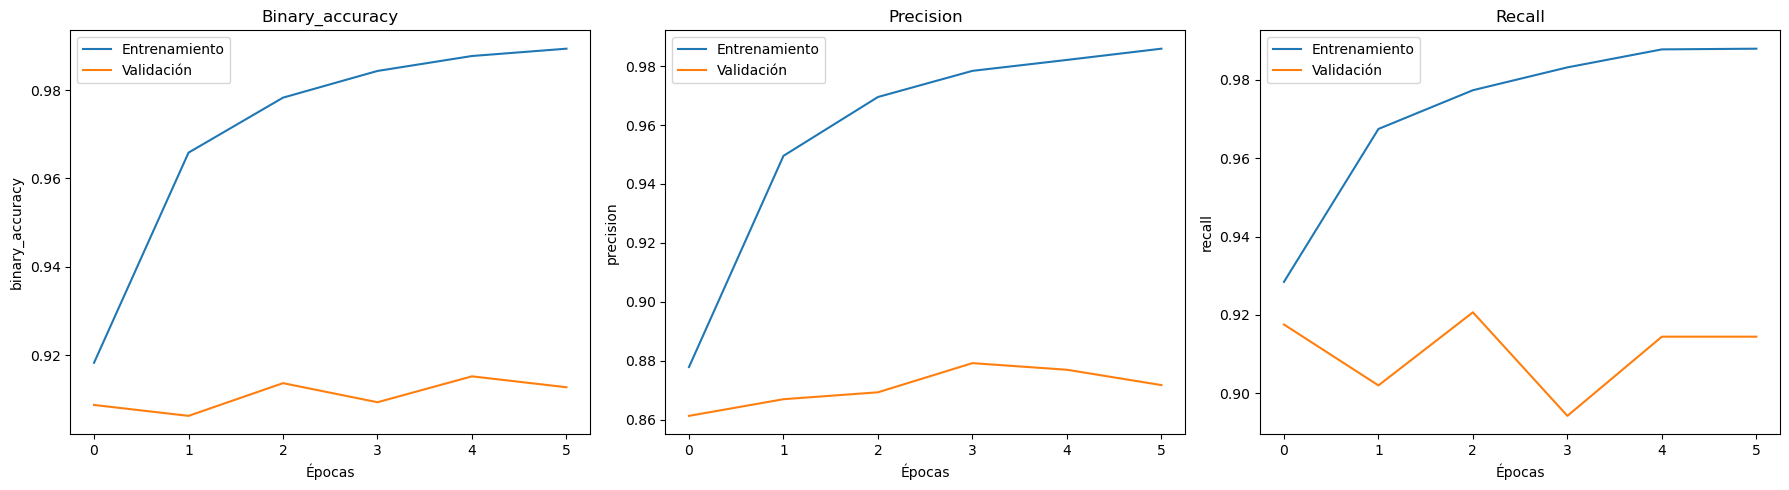

In [16]:
# Dataset de validación sin aumentos
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def weighted_binary_crossentropy(class_weights):
    # Convertir class_weights a tensor, en caso de que aún no lo sea
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Convertir las etiquetas a float32 para evitar problemas de tipo
        y_true = tf.cast(y_true, tf.float32)
        # Calcula la pérdida binaria por cada etiqueta
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Multiplica la pérdida de cada clase por su peso correspondiente.
        # Se asume que y_true y bce tienen forma (batch_size, num_classes)
        weighted_bce = bce * class_weights
        # Se promedia la pérdida a lo largo de las clases y muestras
        return tf.reduce_mean(weighted_bce)
    
    return loss

def build_model(input_shape, num_classes):
    # 1. Cargar el modelo base pre-entrenado (MobileNetV3Large) sin la capa de clasificación final
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=TARGET_SIZE_CHANNEL,
        include_preprocessing=True,  # Aplica el preprocesamiento interno
        include_top=False,  # Excluimos la parte de clasificación original
        weights='imagenet'
    )
    base_model.trainable = False  # Congelamos las capas del modelo base

    # 2. Construir la nueva arquitectura agregando una cabeza de clasificación para multi-label
    inputs = tf.keras.Input(shape=TARGET_SIZE_CHANNEL)
    # Preprocesamiento específico para MobileNetV3
    x = layers.Rescaling(scale=255.0)(inputs)  # Escalar de [0,1] a [0,255]
   
    # Es posible que necesites redimensionar o normalizar si tus imágenes no cumplen el formato:
    x = base_model(x)
    
    # Capas base del modelo (ejemplo)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Capa de salida multi-label
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

# 1. Construcción del modelo con MobileNetV3
print('build_model...')
model = build_model(input_shape=X_bal.shape[1:], num_classes=len(LABEL_COLUMNS))
print('build_model OK')

print('loss...')
# Ejemplo de uso:
loss_fn = weighted_binary_crossentropy(class_weights)
print('loss OK')

# Optimizador con learning rate adaptativo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# 2. Compilación del modelo
print('compile...')
model.compile(
    optimizer=optimizer,
    loss=loss_fn,  # Loss estándar para multi-label
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
print('compile OK')

print('fit inicial...')
# 3. Entrenamiento inicial (solo capas nuevas)
initial_epochs = 15
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

print('fit inicial OK')
# Llamada a la función para mostrar las gráficas
plot_training_history(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          276512    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496 

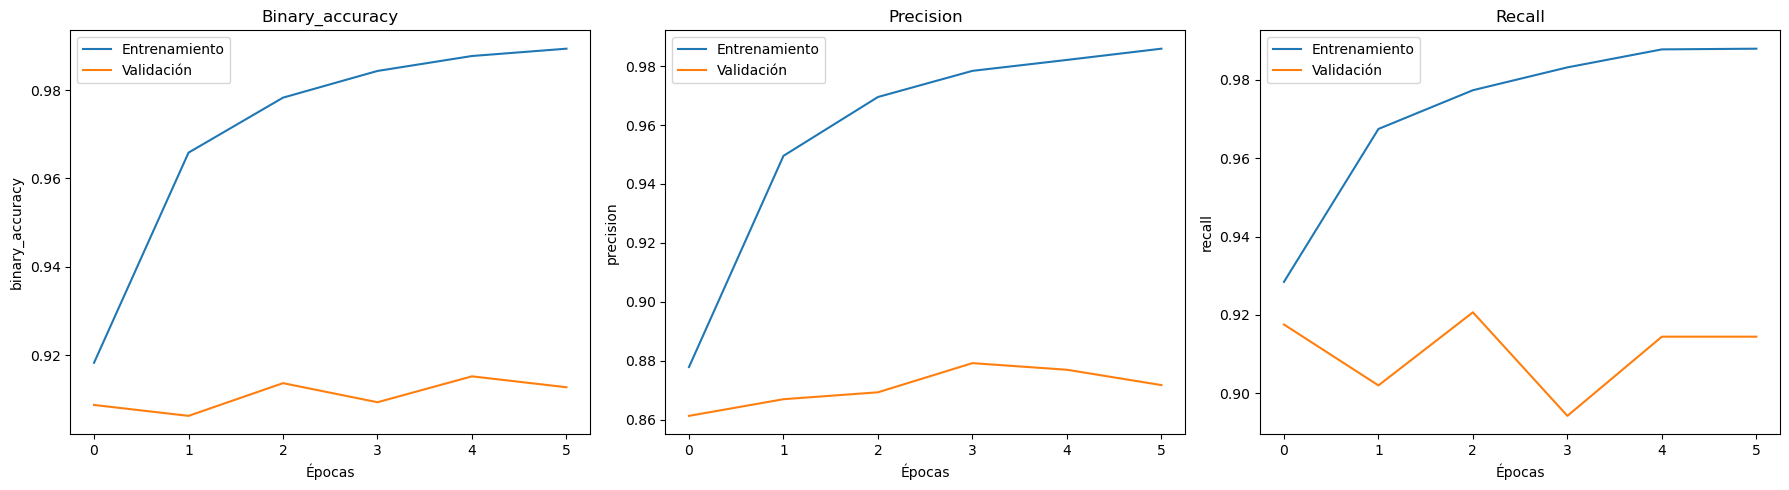

fit OK
save...
save OK


In [19]:
model.summary()

# Ver arquitectura detallada
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# 4. Fine-tuning (descongelar capas superiores)
# Descongelar las últimas 15 capas del modelo base
base_model = model.layers[2]  # Índice de la capa MobileNetV3
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Recompilar con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Entrenar con fine-tuning
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

print('fit...')
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

# Llamada a la función para mostrar las gráficas
plot_training_history(history)
print('fit OK')

# Guardar el modelo entrenado
print('save...')
model.save("mobilenetv3_classifier.v.5.keras")
print('save OK')

In [20]:
from sklearn.metrics import classification_report

print('predict...')
# Generar predicciones
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5).astype(int)
print('predict OK')

# Reporte detallado por clase
print(classification_report(
    y_test,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))

predict...
26/26 [==============================] - 12s 359ms/step
predict OK
              precision    recall  f1-score   support

   direccion       0.70      0.89      0.79       101
     fachada       0.76      0.82      0.79       108
       envio       0.93      0.97      0.95       610
    etiqueta       0.87      0.90      0.88       467

   micro avg       0.87      0.93      0.90      1286
   macro avg       0.82      0.90      0.85      1286
weighted avg       0.88      0.93      0.90      1286
 samples avg       0.88      0.93      0.88      1286



1/1 [==============================] - 2s 2s/step


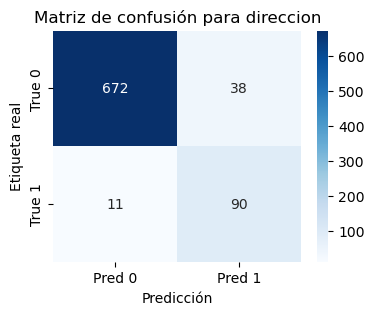

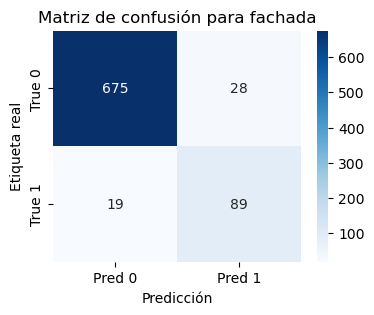

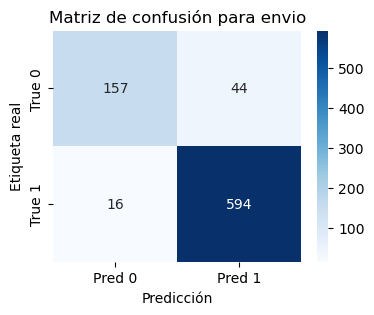

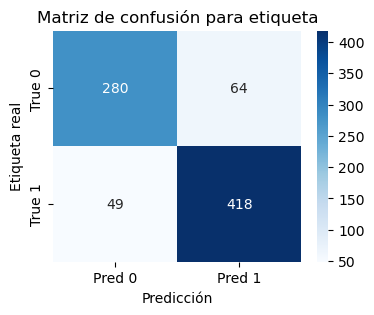

In [21]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Acumula las etiquetas verdaderas y las predicciones en listas
y_true_list = []
y_pred_list = []

# Itera sobre el dataset de validación
for x_batch, y_batch in val_dataset:
    # Genera las predicciones para el batch
    preds = model.predict(x_batch)
    # Convierte las probabilidades a etiquetas binarias (umbral de 0.5, ajústalo si es necesario)
    preds_binary = (preds > 0.5).astype(int)
    
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(preds_binary)

# Concatena todos los batches en arreglos completos
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calcula la matriz de confusión para cada clase
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Recorre y muestra la matriz de confusión de cada clase
for i, cm in enumerate(mcm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Pred 0", "Pred 1"], 
                yticklabels=["True 0", "True 1"])
    plt.title(f"Matriz de confusión para {LABEL_COLUMNS[i]}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.show()
